<h1 id="title">Predicting Motor Vehicle Accident Severity in Seattle, Washington by Oversampling Minority Classes to Achieve Balanced Training Data<\h1>

In [1]:
# Import packages and modules.
import io
import itertools
import matplotlib as mpl
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import os
import pandas as pd
import pylab as pl
import scipy
import scipy.optimize as opt
import seaborn as sns
import sklearn
import sys
import timeit
import warnings
from matplotlib.ticker import NullFormatter
from scipy import optimize
from scipy.optimize import curve_fit
from scipy.sparse import csr_matrix
from sklearn import linear_model
from sklearn import metrics
from sklearn import pipeline
from sklearn import preprocessing
from sklearn import svm
from sklearn import tree
from sklearn import utils
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import jaccard_score
from sklearn.metrics import log_loss
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import KFold
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import resample
from sklearn.utils import shuffle
from sklearn.exceptions import ConvergenceWarning
from timeit import default_timer
%matplotlib inline

In [2]:
warnings.filterwarnings("ignore", category=ConvergenceWarning, module="sklearn")

In [3]:
# Define the starting time for this notebook. 
notebook_start_time = default_timer()

In [4]:
# This function computes the time elapsed in seconds from the 
# time represented by the first parameter (start_time)
# to the time represented by the second parameter (end_time)
# This function requires the os package to be imported.
def elapsed_time(start_time = notebook_start_time):
    return default_timer() - start_time   

In [5]:
# This function prints the time elapsed in seconds from the 
# time represented by the first parameter (start_time)
# to the time represented by the second parameter (end_time)
# This function requires the os package to be imported.
def print_elapsed_time(start_time = notebook_start_time):
    print("Elapsed time is", elapsed_time(start_time), "seconds.")
    return None

In [6]:
# Create a list of display options.
list_of_display_options_fully_qualified_names = str(\
"pd.options.display.chop_threshold, pd.options.display.float_format, pd.options.display.max_info_columns, pd.options.display.notebook_repr_html, \
pd.options.display.colheader_justify, pd.options.display.html, pd.options.display.max_info_rows, pd.options.display.pprint_nest_depth, \
pd.options.display.column_space, pd.options.display.large_repr, pd.options.display.max_rows, pd.options.display.precision, \
pd.options.display.date_dayfirst, pd.options.display.latex, pd.options.display.max_seq_items, pd.options.display.show_dimensions, \
pd.options.display.date_yearfirst, pd.options.display.max_categories, pd.options.display.memory_usage, pd.options.display.unicode, \
pd.options.display.encoding, pd.options.display.max_columns, pd.options.display.min_rows, pd.options.display.width, \
pd.options.display.expand_frame_repr, pd.options.display.max_colwidth, pd.options.display.multi_sparse").split(sep=', ')

# Initialize an empty list to store all the short names for display options.
list_of_display_options_short_names = list()
# For each fully qualified option name,
# get the option's short name and add it to the list of short names.
for fully_qualified_option_name in list_of_display_options_fully_qualified_names:
    # Get short option name.
    short_option_name = fully_qualified_option_name.split(sep='.')[-1]
    
    # Add short option name to list of display option short names.
    list_of_display_options_short_names.append(short_option_name)

# Define dictionary of display option settings.
dict_of_display_option_settings_short_names=\
{"max_info_columns": 1000,\
"colheader_justify": "right",\
"max_info_rows": 1000000,\
"column_space": 1000,\
"max_rows": 1000000,\
"precision": 9,\
"max_seq_items": 1000000000000,\
"show_dimensions": True,\
"max_categories": 100,\
"memory_usage": True,\
"max_columns": 1000,\
"max_colwidth": 1000,\
"float_format": lambda x: '%.9f' % x}

# Set pandas display options using dictionary of short names,
# and display the options/value pairs.
print("Setting display options...")
for key in list(dict_of_display_option_settings_short_names.keys()):
    # Set display option.
    pd.set_option(key, dict_of_display_option_settings_short_names[key])
    # Print display option name and value.
    print(key, ": ", pd.get_option(key), sep='')

Setting display options...
max_info_columns: 1000
colheader_justify: right
max_info_rows: 1000000
column_space: 1000
max_rows: 1000000
precision: 9
max_seq_items: 1000000000000
show_dimensions: True
max_categories: 100
memory_usage: True
max_columns: 1000
max_colwidth: 1000
float_format: <function <lambda> at 0x7f35023ce310>


In [7]:
# Set seed for random number generator.
# seed = np.int(os.times()[4]) # Use this line for better pseudo-random behavior.
seed = 42
print(seed)

42


In [8]:
# Attribute Information URL: https://www.seattle.gov/Documents/Departments/SDOT/GIS/Collisions_OD.pdf
# Read the Collisions Data CSV file and store it as a DataFrame.
# url="https://opendata.arcgis.com/datasets/5b5c745e0f1f48e7a53acec63a0022ab_0.csv" # HTTPError at 202009151050, using local copy of .csv instead.
# print(os.listdir("..")) # Print list of contents of current working directory.
local_path_to_csv = '~/IBM Data Science Professional Certificate Course/Course 9 - Applied Data Science Capstone/projects/Collisions.csv'
df=pd.read_csv(local_path_to_csv, low_memory=False)

In [9]:
# View the first few rows of the collisions DataFrame.
df.head()

,X,Y,OBJECTID,INCKEY,COLDETKEY,REPORTNO,STATUS,ADDRTYPE,INTKEY,LOCATION,EXCEPTRSNCODE,EXCEPTRSNDESC,SEVERITYCODE,SEVERITYDESC,COLLISIONTYPE,PERSONCOUNT,PEDCOUNT,PEDCYLCOUNT,VEHCOUNT,INJURIES,SERIOUSINJURIES,FATALITIES,INCDATE,INCDTTM,JUNCTIONTYPE,SDOT_COLCODE,SDOT_COLDESC,INATTENTIONIND,UNDERINFL,WEATHER,ROADCOND,LIGHTCOND,PEDROWNOTGRNT,SDOTCOLNUM,SPEEDING,ST_COLCODE,ST_COLDESC,SEGLANEKEY,CROSSWALKKEY,HITPARKEDCAR
0,-122.320757054,47.609407946,1,328476,329976,EA08706,Matched,Block,nan,BROADWAY BETWEEN E COLUMBIA ST AND BOYLSTON AVE,,NaN,1,Property Damage Only Collision,Sideswipe,2,0,0,2,0,0,0,2020/01/22 00:00:00+00,1/22/2020 3:21:00 PM,Mid-Block (not related to intersection),11.000000000,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, FRONT END AT ANGLE",NaN,N,Raining,Wet,Dark - Street Lights On,NaN,nan,NaN,11,From same direction - both going straight - both moving - sideswipe,0,0,N
1,-122.319560827,47.662220664,2,328142,329642,EA06882,Matched,Block,nan,8TH AVE NE BETWEEN NE 45TH E ST AND NE 47TH ST,,NaN,1,Property Damage Only Collision,Parked Car,2,0,0,2,0,0,0,2020/01/07 00:00:00+00,1/7/2020 8:00:00 AM,Mid-Block (not related to intersection),15.000000000,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, RIGHT SIDE SIDESWIPE",NaN,N,Clear,Dry,Daylight,NaN,nan,NaN,32,One parked--one moving,0,0,Y
2,-122.327524508,47.604393273,3,20700,20700,1181833,Unmatched,Block,nan,JAMES ST BETWEEN 6TH AVE AND 7TH AVE,NaN,NaN,0,Unknown,NaN,0,0,0,0,0,0,0,2004/01/30 00:00:00+00,1/30/2004,Mid-Block (but intersection related),11.000000000,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, FRONT END AT ANGLE",NaN,NaN,NaN,NaN,NaN,NaN,4030032.000000000,NaN,NaN,NaN,0,0,N
3,-122.327524934,47.708621579,4,332126,333626,M16001640,Unmatched,Block,nan,NE NORTHGATE WAY BETWEEN 1ST AVE NE AND NE NORTHGATE DR,,NaN,0,Unknown,NaN,0,0,0,0,0,0,0,2016/01/23 00:00:00+00,1/23/2016,Mid-Block (not related to intersection),11.000000000,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, FRONT END AT ANGLE",NaN,NaN,NaN,NaN,NaN,NaN,nan,NaN,,NaN,0,0,N
4,-122.292120049,47.559009080,5,328238,329738,3857118,Unmatched,Block,nan,M L KING JR ER WAY S BETWEEN S ANGELINE ST AND S EDMUNDS ST,,NaN,0,Unknown,NaN,0,0,0,0,0,0,0,2020/01/26 00:00:00+00,1/26/2020,Mid-Block (not related to intersection),28.000000000,MOTOR VEHICLE RAN OFF ROAD - HIT FIXED OBJECT,NaN,NaN,NaN,NaN,NaN,NaN,nan,NaN,,NaN,0,0,N


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 221389 entries, 0 to 221388
Data columns (total 40 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   X                213918 non-null  float64
 1   Y                213918 non-null  float64
 2   OBJECTID         221389 non-null  int64  
 3   INCKEY           221389 non-null  int64  
 4   COLDETKEY        221389 non-null  int64  
 5   REPORTNO         221389 non-null  object 
 6   STATUS           221389 non-null  object 
 7   ADDRTYPE         217677 non-null  object 
 8   INTKEY           71884 non-null   float64
 9   LOCATION         216801 non-null  object 
 10  EXCEPTRSNCODE    100986 non-null  object 
 11  EXCEPTRSNDESC    11779 non-null   object 
 12  SEVERITYCODE     221388 non-null  object 
 13  SEVERITYDESC     221389 non-null  object 
 14  COLLISIONTYPE    195159 non-null  object 
 15  PERSONCOUNT      221389 non-null  int64  
 16  PEDCOUNT         221389 non-null  int6

In [11]:
print_elapsed_time(notebook_start_time)

Elapsed time is 9.878835309995338 seconds.


<h2 id="data_wrangling">Data Wrangling</h2>

Steps for working with missing data:
<ol>
    <li>Identify missing data.</li>
    <li>Deal with missing data.</li>
    <li>Correct data format.</li>
</ol>

<h3 id="identifying_missing_data">Identifying Missing Data</h3>

The metadata document that accompanied the data set indicates that certain columns have "sentinel" values
that indicate an unknown or missing value. Each of these missing values will first be converted into NaN.
Subsequently, the NaN values will be dropped from the DataFrame.

In [12]:
# If any row of the collisions DataFrame contains a sentinel value representing "unknown",
# then replace it with NaN. 
# Sentinels for "unknown" are listed in the metadata document that accompanies the dataset.
df_unknowns_converted_to_nan = df.replace(to_replace=\
{"EXCEPTRSNCODE": " ",\
 "EXCEPTRSNDESC": "Not Enough Information, or Insufficient Location Information",\
 "SEVERITYCODE": "0",\
 "SEVERITYDESC": "Unknown",\
 "JUNCTIONTYPE": "Unknown",\
 "WEATHER": "Unknown",\
 "ROADCOND": "Unknown",\
 "LIGHTCOND": "Unknown",\
 "SDOT_COLCODE": float(0),\
 "SDOT_COLDESC": "NOT ENOUGH INFORMATION / NOT APPLICABLE",\
 "ST_COLCODE": " ",\
 "ST_COLDESC": "Not stated"},\
value=np.nan, inplace=False, limit=None, regex=False, method='pad')

df_unknowns_converted_to_nan.replace(to_replace={"ST_COLCODE": "0", }, value=np.nan, inplace=True, limit=None, regex=False, method='pad')

In [13]:
print_elapsed_time(notebook_start_time)

Elapsed time is 16.90494649799075 seconds.


<h3 id="deal_with_missing_data">Deal with Missing Data</h3>

<ol>
    <li>Drop the Data
        <ol>
            <li>Drop entire row.</li>
            <li>Drop entire column.</li>
        </ol>
    </li>
    <li>Replace the Data
        <ol>
            <li>Replace data by mean.</li>
            <li>Replace data by frequency.</li>
            <li>Replace data based on other functions.</li>
        </ol>
    </li>
        
</ol>

Whole columns should be dropped only if most entries in the column are empty.

In [14]:
print(list(df.columns))

['X', 'Y', 'OBJECTID', 'INCKEY', 'COLDETKEY', 'REPORTNO', 'STATUS', 'ADDRTYPE', 'INTKEY', 'LOCATION', 'EXCEPTRSNCODE', 'EXCEPTRSNDESC', 'SEVERITYCODE', 'SEVERITYDESC', 'COLLISIONTYPE', 'PERSONCOUNT', 'PEDCOUNT', 'PEDCYLCOUNT', 'VEHCOUNT', 'INJURIES', 'SERIOUSINJURIES', 'FATALITIES', 'INCDATE', 'INCDTTM', 'JUNCTIONTYPE', 'SDOT_COLCODE', 'SDOT_COLDESC', 'INATTENTIONIND', 'UNDERINFL', 'WEATHER', 'ROADCOND', 'LIGHTCOND', 'PEDROWNOTGRNT', 'SDOTCOLNUM', 'SPEEDING', 'ST_COLCODE', 'ST_COLDESC', 'SEGLANEKEY', 'CROSSWALKKEY', 'HITPARKEDCAR']


In [15]:
# Drop any column from the collisions DataFrame if it satisfies at least one of the following conditions:
# 1) more than 15% of the column's data is NaN;
# 2) the column only contains unique identification keys, or information not useful for model building;
# 3) the column's data is categorical but does not fit into a small (< 15) number of categories;
# 4) information in the column is redundant because it is already represented by another column;
# 5) it is not clear how to interpret the column's data.
list_of_columns_to_drop = ["ADDRTYPE",\
                           "STATUS",\
                           "OBJECTID",\
                           "INCKEY",\
                           "COLDETKEY",\
                           "REPORTNO",\
                           "INTKEY",\
                           "LOCATION",\
                           "EXCEPTRSNCODE",\
                           "EXCEPTRSNDESC",\
                           "SEVERITYDESC",\
                           "PERSONCOUNT",\
                           "INCDATE",\
                           "INCDTTM",\
                           "JUNCTIONTYPE",\
                           "SDOT_COLCODE",\
                           "SDOT_COLDESC",\
                           "INATTENTIONIND",\
                           "UNDERINFL",\
                           "PEDROWNOTGRNT",\
                           "SDOTCOLNUM",\
                           "SPEEDING",\
                           "ST_COLCODE",\
                           "ST_COLDESC",\
                           "SEGLANEKEY",\
                           "CROSSWALKKEY",\
                           "HITPARKEDCAR"]

In [16]:
# Drop the selected columns from the DataFrame after converting unknowns to NaN.
# Store the result in a new DataFrame.
df_drop_columns = df_unknowns_converted_to_nan.drop(columns=list_of_columns_to_drop, inplace=False)

In [17]:
# Drop any row that contains at least one NaN.
df_drop_columns_and_rows = df_drop_columns.dropna(axis="index", how="any", thresh=None, subset=None, inplace=False)

In [18]:
print_elapsed_time(notebook_start_time)

Elapsed time is 18.28456560696941 seconds.


<h3 id="correct_data_format">Correct Data Format</h3>

Ensure that each data type is appropriate for the corresponding feature.
Cast columns of type "object" as type "category", but leave all other column types unaltered.

In [19]:
# Create new DataFrame to store converted data types.
df_converted = pd.DataFrame()

for column in list(df_drop_columns_and_rows.columns):
    if (df_drop_columns_and_rows[column].dtype in [np.dtype('object')]):
        df_converted[column] = df_drop_columns_and_rows[column].astype('category')
    # Copy all other columns to new DataFrame without changing their types.
    else:
        df_converted[column] = df_drop_columns_and_rows[column]

In [20]:
# Create DataFrame of categorical or integer columns, inclusive.
df_categorical = df_converted.select_dtypes(include=["category", "integer"])

In [21]:
print_elapsed_time(notebook_start_time)

Elapsed time is 19.07964843395166 seconds.


<h2 id="feature_selection">Feature selection</h2>

#### Features before One-Hot Encoding

In [22]:
df_categorical.head()

,SEVERITYCODE,COLLISIONTYPE,PEDCOUNT,PEDCYLCOUNT,VEHCOUNT,INJURIES,SERIOUSINJURIES,FATALITIES,WEATHER,ROADCOND,LIGHTCOND
0,1,Sideswipe,0,0,2,0,0,0,Raining,Wet,Dark - Street Lights On
1,1,Parked Car,0,0,2,0,0,0,Clear,Dry,Daylight
5,1,Rear Ended,0,0,2,0,0,0,Clear,Dry,Daylight
6,1,Other,0,0,1,0,0,0,Clear,Wet,Daylight
8,1,Sideswipe,0,0,2,0,0,0,Overcast,Dry,Daylight


In [23]:
df_categorical.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 171872 entries, 0 to 221388
Data columns (total 11 columns):
 #   Column           Non-Null Count   Dtype   
---  ------           --------------   -----   
 0   SEVERITYCODE     171872 non-null  category
 1   COLLISIONTYPE    171872 non-null  category
 2   PEDCOUNT         171872 non-null  int64   
 3   PEDCYLCOUNT      171872 non-null  int64   
 4   VEHCOUNT         171872 non-null  int64   
 5   INJURIES         171872 non-null  int64   
 6   SERIOUSINJURIES  171872 non-null  int64   
 7   FATALITIES       171872 non-null  int64   
 8   WEATHER          171872 non-null  category
 9   ROADCOND         171872 non-null  category
 10  LIGHTCOND        171872 non-null  category
dtypes: category(5), int64(6)
memory usage: 10.0 MB


In [24]:
print_elapsed_time(notebook_start_time)

Elapsed time is 19.449529935023747 seconds.


<h2 id="imbalanced_data">Dealing with Imbalanced Data</h2>

Because the data is imbalanced, we split the DataFrame into four DataFrames, one for each value of the SEVERITYCODE feature.

In [25]:
print("SEVERITYCODE relative frequencies:")
print(df_categorical["SEVERITYCODE"].value_counts(normalize=True, dropna=False))

SEVERITYCODE relative frequencies:
1    0.657943120
2    0.323036911
2b   0.017111571
3    0.001908397
Name: SEVERITYCODE, Length: 4, dtype: float64


In [26]:
print("SEVERITYCODE relative frequencies:")
print(df_categorical["SEVERITYCODE"].value_counts(normalize=False, dropna=False))

SEVERITYCODE relative frequencies:
1     113082
2      55521
2b      2941
3        328
Name: SEVERITYCODE, Length: 4, dtype: int64


In [27]:
df_class_1 = df_categorical[df_categorical['SEVERITYCODE'] == '1']
df_class_2 = df_categorical[df_categorical['SEVERITYCODE'] == '2']
df_class_2b = df_categorical[df_categorical['SEVERITYCODE'] == '2b']
df_class_3 = df_categorical[df_categorical['SEVERITYCODE'] == '3']

In [28]:
print("SEVERITYCODE relative frequencies:")
print(df_class_1["SEVERITYCODE"].value_counts(normalize=False, dropna=False))

SEVERITYCODE relative frequencies:
1     113082
3          0
2b         0
2          0
Name: SEVERITYCODE, Length: 4, dtype: int64


In [29]:
print("SEVERITYCODE relative frequencies:")
print(df_class_2["SEVERITYCODE"].value_counts(normalize=False, dropna=False))

SEVERITYCODE relative frequencies:
2     55521
3         0
2b        0
1         0
Name: SEVERITYCODE, Length: 4, dtype: int64


In [30]:
print("SEVERITYCODE relative frequencies:")
print(df_class_2b["SEVERITYCODE"].value_counts(normalize=False, dropna=False))

SEVERITYCODE relative frequencies:
2b    2941
3        0
2        0
1        0
Name: SEVERITYCODE, Length: 4, dtype: int64


In [31]:
print("SEVERITYCODE relative frequencies:")
print(df_class_3["SEVERITYCODE"].value_counts(normalize=False, dropna=False))

SEVERITYCODE relative frequencies:
3     328
2b      0
2       0
1       0
Name: SEVERITYCODE, Length: 4, dtype: int64


In [32]:
# Store and print the size of the all classes.
class_1_size = len(df_class_1)
class_2_size = len(df_class_2)
class_2b_size = len(df_class_2b)
class_3_size = len(df_class_3)
print('class_1_size =', class_1_size)
print('class_2_size =', class_2_size)
print('class_2b_size =', class_2b_size)
print('class_3_size =', class_3_size)
print()
# Store and print the size of the minority class.
minority_class_size = len(df_class_3)
print('minority_class_size =', minority_class_size)

class_1_size = 113082
class_2_size = 55521
class_2b_size = 2941
class_3_size = 328

minority_class_size = 328


In [33]:
print_elapsed_time(notebook_start_time)

Elapsed time is 20.627002547029406 seconds.


<h2 id='sample_size_class_3'>Sample all Classes Equally to Create a Balanced Training Set<\h2>

In [34]:
# This parameter determines what fraction of the minority class's data are reserved for testing.
test_size_ratio = .2

# Using train/test splits, set aside part of the data for testing.
df_class_1_train_pre_sampling, df_class_1_test = train_test_split(df_class_1, test_size=test_size_ratio, random_state=seed)
df_class_2_train_pre_sampling, df_class_2_test = train_test_split(df_class_2, test_size=test_size_ratio, random_state=seed)
df_class_2b_train_pre_sampling, df_class_2b_test = train_test_split(df_class_2b, test_size=test_size_ratio, random_state=seed)
df_class_3_train_pre_sampling, df_class_3_test = train_test_split(df_class_3, test_size=test_size_ratio, random_state=seed)

In [35]:
## Build a balanced training set by sampling the pre_sampling training data equally:

# Set a sampling parameter to control the amount of oversampling for the minority class.
# Oversampling requires this parameter to be greater than 1.
# If this parameter is less than or equal to 1, then oversampling will not occur.
sampling_ratio = 5

# Set the replace parameter of the sample method based on the sampling ratio.
# If the sampling_ratio > 1, sample with replacement.
# Otherwise, sample without replacement.
sample_with_replacement = bool(sampling_ratio > 1)
# Print the value of the replace parameter before passing it to the sample method.
print('Sample class 3 with replacement: %s' % (sample_with_replacement))

# Sample the minority class's training set based on the sampling parameter and store the sample for later concatenation.
df_class_3_train = df_class_3_train_pre_sampling.sample(frac=sampling_ratio, replace=sample_with_replacement, axis='index', random_state=seed)

# Store the size of the minority class's training set.
class_3_train_size = df_class_3_train.shape[0]

# Take samples of the other classes' training data, where the sample size taken is equal to the size of the minority class's training set.
# If the sample size to be taken exceeds the number of samples in the class's training data, sample with replacement.

# Sampling for class 2b.
sample_with_replacement = bool(class_3_train_size > df_class_2b_train_pre_sampling.shape[0])
# Print the value of the replace parameter before passing it to the sample method.
print('Sample class 2b with replacement: %s' % (sample_with_replacement))
df_class_2b_train = df_class_2b_train_pre_sampling.sample(n=class_3_train_size, replace=sample_with_replacement, axis='index', random_state=seed)

# Sampling for class 2.
sample_with_replacement = bool(class_3_train_size > df_class_2_train_pre_sampling.shape[0])
# Print the value of the replace parameter before passing it to the sample method.
print('Sample class 2 with replacement: %s' % (sample_with_replacement))
df_class_2_train = df_class_2_train_pre_sampling.sample(n=class_3_train_size, replace=sample_with_replacement, axis='index', random_state=seed)

# Sampling for class 1.
sample_with_replacement = bool(class_3_train_size > df_class_1_train_pre_sampling.shape[0])
# Print the value of the replace parameter before passing it to the sample method.
print('Sample class 1 with replacement: %s' % (sample_with_replacement))
df_class_1_train = df_class_1_train_pre_sampling.sample(n=class_3_train_size, replace=sample_with_replacement, axis='index', random_state=seed)

Sample class 3 with replacement: True
Sample class 2b with replacement: False
Sample class 2 with replacement: False
Sample class 1 with replacement: False


In [36]:
# Make a balanced, unshuffled training set by concatenating the equal sized samples of the training sets for each class.
df_train_balanced_not_shuffled = pd.concat([df_class_1_train, df_class_2_train, df_class_2b_train, df_class_3_train], axis='index')

# Make a not necessarily balanced testing set by concatenating the testing sets for each class.
df_test_not_shuffled = pd.concat([df_class_1_test, df_class_2_test, df_class_2b_test, df_class_3_test], axis='index')

In [37]:
# Shuffle the training set and store it for tuning hyper-parameters and for cross-validation.
df_train = shuffle(df_train_balanced_not_shuffled, random_state=seed)

# Shuffle the unbalanced DataFrame and store it for validation and for comparing the models.
df_test = shuffle(df_test_not_shuffled, random_state=seed)

In [38]:
# Verify the training DataFrame is balanced.
print("SEVERITYCODE relative frequencies:")
print(df_train["SEVERITYCODE"].value_counts(normalize=False, dropna=False))

SEVERITYCODE relative frequencies:
3     1310
2b    1310
2     1310
1     1310
Name: SEVERITYCODE, Length: 4, dtype: int64


In [39]:
# Verify the new DataFrame is balanced.
print("SEVERITYCODE relative frequencies:")
print(df_train["SEVERITYCODE"].value_counts(normalize=True, dropna=False))

SEVERITYCODE relative frequencies:
3    0.250000000
2b   0.250000000
2    0.250000000
1    0.250000000
Name: SEVERITYCODE, Length: 4, dtype: float64


Let's define a feature set represented by the DataFrame X. 

In [40]:
X = df_train.drop(columns=['SEVERITYCODE', 'INJURIES', 'SERIOUSINJURIES', 'FATALITIES'], inplace=False)

In [41]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5240 entries, 143039 to 221266
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   COLLISIONTYPE  5240 non-null   category
 1   PEDCOUNT       5240 non-null   int64   
 2   PEDCYLCOUNT    5240 non-null   int64   
 3   VEHCOUNT       5240 non-null   int64   
 4   WEATHER        5240 non-null   category
 5   ROADCOND       5240 non-null   category
 6   LIGHTCOND      5240 non-null   category
dtypes: category(4), int64(3)
memory usage: 185.8 KB


We also define the data for the target variable, SEVERITYCODE, by the array y:

In [42]:
y = df_train["SEVERITYCODE"].to_numpy()

In [43]:
print_elapsed_time(notebook_start_time)

Elapsed time is 22.00179416197352 seconds.


## Transform the Data 

We normalize the data by transforming it so that it is compatible
with the machine learning estimators we use in this notebook.
We use special care with sparse matrix data so as to not destroy the
structure.

In [44]:
# Create a OneHotEncoder and fit it to the features.
# The fit is performed on the data set before the any test/train splits.
# The data will be encoded as a sparse matrix, the default behavior.
start_time = default_timer()
print("Fitting OneHotEncoder to training data...")
encoder = OneHotEncoder(sparse=True, handle_unknown='error')
encoder.fit(df_categorical.drop(columns=['SEVERITYCODE', 'INJURIES', 'SERIOUSINJURIES', 'FATALITIES'], inplace=False))
#encoder.fit(X)
X = encoder.transform(X)
print("Completed in", elapsed_time(start_time), "seconds.")
# Display the categories of the encoder.
print(encoder.get_feature_names())

Fitting OneHotEncoder to training data...
Completed in 0.31484348594676703 seconds.
['x0_Angles' 'x0_Cycles' 'x0_Head On' 'x0_Left Turn' 'x0_Other'
 'x0_Parked Car' 'x0_Pedestrian' 'x0_Rear Ended' 'x0_Right Turn'
 'x0_Sideswipe' 'x1_0' 'x1_1' 'x1_2' 'x1_3' 'x1_4' 'x1_5' 'x1_6' 'x2_0'
 'x2_1' 'x2_2' 'x3_0' 'x3_1' 'x3_2' 'x3_3' 'x3_4' 'x3_5' 'x3_6' 'x3_7'
 'x3_8' 'x3_9' 'x3_10' 'x3_11' 'x3_12' 'x3_13' 'x3_14' 'x3_15'
 'x4_Blowing Sand/Dirt' 'x4_Clear' 'x4_Fog/Smog/Smoke' 'x4_Other'
 'x4_Overcast' 'x4_Partly Cloudy' 'x4_Raining' 'x4_Severe Crosswind'
 'x4_Sleet/Hail/Freezing Rain' 'x4_Snowing' 'x5_Dry' 'x5_Ice' 'x5_Oil'
 'x5_Other' 'x5_Sand/Mud/Dirt' 'x5_Snow/Slush' 'x5_Standing Water'
 'x5_Wet' 'x6_Dark - No Street Lights' 'x6_Dark - Street Lights Off'
 'x6_Dark - Street Lights On' 'x6_Dark - Unknown Lighting' 'x6_Dawn'
 'x6_Daylight' 'x6_Dusk' 'x6_Other']


In [45]:
type(X)

scipy.sparse.csr.csr_matrix

In [46]:
X.shape

(5240, 62)

In [47]:
y.shape

(5240,)

In [48]:
print_elapsed_time(notebook_start_time)

Elapsed time is 22.846793854958378 seconds.


<h2 id="logistic_regression">Building a Logistic Regression Model<\h2>

In [49]:
t0 = default_timer()
#kfold_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
number_of_folds = 10
logistic_regression_clf = make_pipeline(\
    StandardScaler(with_mean=False),\
    LogisticRegression(solver='saga', multi_class='auto', penalty='l1', max_iter=100, verbose=10, n_jobs=-1, random_state=seed), verbose=True)
scoring = ['f1_macro', 'f1_weighted', 'neg_log_loss', 'precision_macro', 'precision_weighted', 'recall_macro', 'recall_weighted']
logistic_regression_scores = cross_validate(logistic_regression_clf, X, y, scoring=scoring, n_jobs=-1, cv=number_of_folds, return_estimator=True)
print("Logistic regression score keys:", sorted(logistic_regression_scores.keys()))
print('Logistic Regression classifiers constructed in %f seconds.' % elapsed_time(t0))

Logistic regression score keys: ['estimator', 'fit_time', 'score_time', 'test_f1_macro', 'test_f1_weighted', 'test_neg_log_loss', 'test_precision_macro', 'test_precision_weighted', 'test_recall_macro', 'test_recall_weighted']
Logistic Regression classifiers constructed in 19.942639 seconds.


In [50]:
print_elapsed_time(notebook_start_time)

Elapsed time is 42.965061811031774 seconds.


<h2 id="support_vector_machine">Building a Support Vector Machine<\h2>

In [51]:
t0 = default_timer()
number_of_folds = 10
#kfold_cv = StratifiedKFold(n_splits=number_of_folds, shuffle=True, random_state=seed)
linear_svc_clf = make_pipeline(\
    StandardScaler(with_mean=False),\
    LinearSVC(penalty='l1', dual=False, random_state=seed, max_iter=100), verbose=True)
scoring = ['f1_macro', 'f1_weighted', 'precision_macro', 'precision_weighted', 'recall_macro', 'recall_weighted']
linear_svc_scores = cross_validate(linear_svc_clf, X, y, scoring=scoring, n_jobs=-1, cv=number_of_folds, return_estimator=True)
print("Support Vector Machine score keys:", sorted(linear_svc_scores.keys()))
print('Support Vector Machine classifiers constructed in %f seconds.' % elapsed_time(t0))

Support Vector Machine score keys: ['estimator', 'fit_time', 'score_time', 'test_f1_macro', 'test_f1_weighted', 'test_precision_macro', 'test_precision_weighted', 'test_recall_macro', 'test_recall_weighted']
Support Vector Machine classifiers constructed in 3.490025 seconds.


In [52]:
print_elapsed_time(notebook_start_time)

Elapsed time is 46.58676423295401 seconds.


<h2 id="knn_classifier">Building a k-Nearsest Neighbors Classifier<\h2>

In [53]:
t0 = default_timer()
number_of_folds = 10

# Set maximum number of neighbors based on number of samples and number of folds to prevent errors.
maximum_number_of_neighbors = min(200, np.int((X.shape[0] * (1 - 1 / number_of_folds))) - 1) # Take the smaller of the two parameters for min().
k_neighbors_pipeline = make_pipeline(\
    StandardScaler(with_mean=False),\
    KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski', metric_params=None, n_jobs=-1, p=1, weights='distance'), verbose=True)

# Use only odd numbers of neighbors to avoid ties.
grid_parameters = {'kneighborsclassifier__n_neighbors': range(3, maximum_number_of_neighbors, 2)}
scoring = ['recall_weighted']
grid_search_cv = GridSearchCV(k_neighbors_pipeline, param_grid=grid_parameters,\
                              scoring=scoring, \
                              n_jobs=-1, refit='recall_weighted', cv=number_of_folds, verbose=50, pre_dispatch=2**10, error_score='raise',\
                              return_train_score=False)

grid_search_cv.fit(X, y)

Fitting 10 folds for each of 99 candidates, totalling 990 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:    8.8s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    9.2s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:   11.2s
[Parallel(n_jobs=-1)]: Done  27 out of 990 | elapsed:  

GridSearchCV(cv=10, error_score='raise',
             estimator=Pipeline(steps=[('standardscaler',
                                        StandardScaler(with_mean=False)),
                                       ('kneighborsclassifier',
                                        KNeighborsClassifier(n_jobs=-1, p=1,
                                                             weights='distance'))],
                                verbose=True),
             n_jobs=-1,
             param_grid={'kneighborsclassifier__n_neighbors': range(3, 200, 2)},
             pre_dispatch=1024, refit='recall_weighted',
             scoring=['recall_weighted'], verbose=50)

In [54]:
print('Completed grid search in %f seconds' % (elapsed_time(t0)))

Completed grid search in 463.719013 seconds


In [55]:
# Store best KNeighborsClassifier from GridSearchCV and print its parameters.
k_neighbors_clf = grid_search_cv.best_estimator_
print('Best KNeighborsClassifier parameters:')
for key in k_neighbors_clf.get_params().keys():
    print(key, ':', k_neighbors_clf.get_params()[key])

Best KNeighborsClassifier parameters:
memory : None
steps : [('standardscaler', StandardScaler(with_mean=False)), ('kneighborsclassifier', KNeighborsClassifier(n_jobs=-1, n_neighbors=131, p=1, weights='distance'))]
verbose : True
standardscaler : StandardScaler(with_mean=False)
kneighborsclassifier : KNeighborsClassifier(n_jobs=-1, n_neighbors=131, p=1, weights='distance')
standardscaler__copy : True
standardscaler__with_mean : False
standardscaler__with_std : True
kneighborsclassifier__algorithm : auto
kneighborsclassifier__leaf_size : 30
kneighborsclassifier__metric : minkowski
kneighborsclassifier__metric_params : None
kneighborsclassifier__n_jobs : -1
kneighborsclassifier__n_neighbors : 131
kneighborsclassifier__p : 1
kneighborsclassifier__weights : distance


In [56]:
t0 = default_timer()
number_of_folds = 10
#kfold_cv = StratifiedKFold(n_splits=number_of_folds, shuffle=True, random_state=seed)
scoring = ['f1_macro', 'f1_weighted', 'neg_log_loss', 'precision_macro', 'precision_weighted', 'recall_macro', 'recall_weighted']
k_neighbors_scores = cross_validate(k_neighbors_clf, X, y, scoring=scoring, n_jobs=-1, cv=number_of_folds, return_estimator=True)
print("k-Neighbors score keys:", sorted(k_neighbors_scores.keys()))
print('k-Neighbors Classifiers constructed in %f seconds.' % elapsed_time(t0))

k-Neighbors score keys: ['estimator', 'fit_time', 'score_time', 'test_f1_macro', 'test_f1_weighted', 'test_neg_log_loss', 'test_precision_macro', 'test_precision_weighted', 'test_recall_macro', 'test_recall_weighted']
k-Neighbors Classifiers constructed in 16.895881 seconds.


In [57]:
print_elapsed_time(notebook_start_time)

Elapsed time is 527.6595322339563 seconds.


## Test the Models and Compare their Performance

In [58]:
# Set starting time for reports and graphics.
t0 = default_timer()

In [59]:
#df_categorical.info()
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34377 entries, 50136 to 109788
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   SEVERITYCODE     34377 non-null  category
 1   COLLISIONTYPE    34377 non-null  category
 2   PEDCOUNT         34377 non-null  int64   
 3   PEDCYLCOUNT      34377 non-null  int64   
 4   VEHCOUNT         34377 non-null  int64   
 5   INJURIES         34377 non-null  int64   
 6   SERIOUSINJURIES  34377 non-null  int64   
 7   FATALITIES       34377 non-null  int64   
 8   WEATHER          34377 non-null  category
 9   ROADCOND         34377 non-null  category
 10  LIGHTCOND        34377 non-null  category
dtypes: category(5), int64(6)
memory usage: 2.0 MB


In [60]:
# Print the relative frequencies for the validation DataFrame.
print("SEVERITYCODE relative frequencies:")
print(df_test["SEVERITYCODE"].value_counts(normalize=False, dropna=False))

SEVERITYCODE relative frequencies:
1     22617
2     11105
2b      589
3        66
Name: SEVERITYCODE, Length: 4, dtype: int64


In [61]:
# Print the relative frequencies for the validation DataFrame.
print("SEVERITYCODE relative frequencies:")
print(df_test["SEVERITYCODE"].value_counts(normalize=True, dropna=False))

SEVERITYCODE relative frequencies:
1    0.657910812
2    0.323035751
2b   0.017133549
3    0.001919888
Name: SEVERITYCODE, Length: 4, dtype: float64


In [62]:
# Encode the data using the OneHotEncoder fitted before the models were created.
start_time = default_timer()
# print("Transforming full data set's feature set using OneHotEncoder...")
# X = df_categorical.drop(columns=['SEVERITYCODE', 'INJURIES', 'SERIOUSINJURIES', 'FATALITIES'], inplace=False)
# X = encoder.transform(X)
print('Transforming features using OneHotEncoder...')
X_test = df_test.drop(columns=['SEVERITYCODE', 'INJURIES', 'SERIOUSINJURIES', 'FATALITIES'], inplace=False)
X_test = encoder.transform(X_test)
print("Encoding completed in", elapsed_time(start_time), "seconds.")

Transforming features using OneHotEncoder...
Encoding completed in 0.27635074395220727 seconds.


In [63]:
y_test = df_test['SEVERITYCODE'].to_numpy()

In [64]:
X_test.shape

(34377, 62)

In [65]:
y_test.shape

(34377,)

In [66]:
print_elapsed_time(notebook_start_time)

Elapsed time is 529.0444235559553 seconds.


In [67]:
# Report statistics of the models built for each fold of the cross-validation.
print('Logistic Regression Cross-validation Scores:')
print()
for key in sorted(logistic_regression_scores.keys()):
    if key != 'estimator':
        print('%s: mean = %f, std = %f' % (key, np.mean(logistic_regression_scores[key]), np.std(logistic_regression_scores[key])), sep='')
        print('%s :%s' % (key, logistic_regression_scores[key]), sep='')
        print()

Logistic Regression Cross-validation Scores:

fit_time: mean = 2.804739, std = 0.103376
fit_time :[2.7151587  2.86107302 2.84810829 2.66767001 2.87135291 2.85964894
 2.87299347 2.65730023 2.98410106 2.70998335]

score_time: mean = 0.083124, std = 0.005800
score_time :[0.08019423 0.08188081 0.08004475 0.07947779 0.0806973  0.09534335
 0.08310485 0.09338522 0.07775211 0.07936406]

test_f1_macro: mean = 0.481583, std = 0.013765
test_f1_macro :[0.4993591  0.46748582 0.47340841 0.48170994 0.50201951 0.47654729
 0.48940628 0.47259304 0.45821736 0.4950833 ]

test_f1_weighted: mean = 0.481583, std = 0.013765
test_f1_weighted :[0.4993591  0.46748582 0.47340841 0.48170994 0.50201951 0.47654729
 0.48940628 0.47259304 0.45821736 0.4950833 ]

test_neg_log_loss: mean = -1.126360, std = 0.020573
test_neg_log_loss :[-1.08885855 -1.12743966 -1.15252305 -1.11082979 -1.11023396 -1.11527691
 -1.14621955 -1.13533282 -1.1578025  -1.11908084]

test_precision_macro: mean = 0.501153, std = 0.015489
test_precis

Logistic Regression Model 1 of 10:

              precision    recall  f1-score   support

           1   0.867337  0.484193  0.621457     22617
           2   0.406258  0.551824  0.467983     11105
          2b   0.051139  0.217317  0.082794       589
           3   0.007925  0.500000  0.015603        66

    accuracy                       0.501498     34377
   macro avg   0.333165  0.438334  0.296959     34377
weighted avg   0.702758  0.501498  0.561487     34377



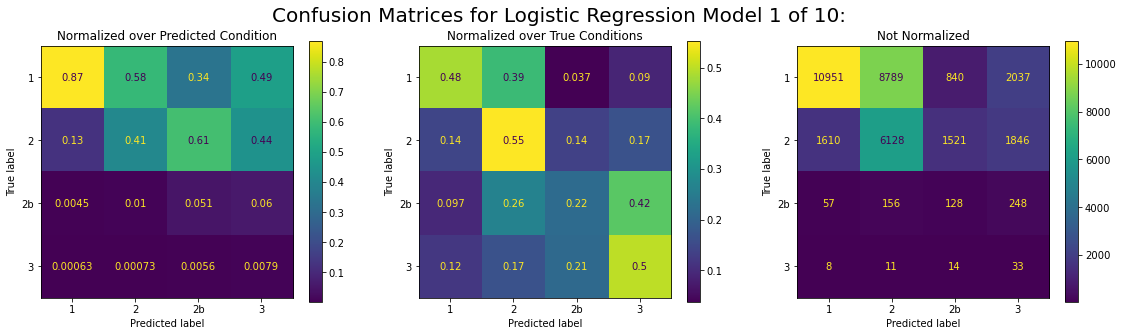

Logistic Regression Model 2 of 10:

              precision    recall  f1-score   support

           1   0.868836  0.482955  0.620819     22617
           2   0.407670  0.560018  0.471851     11105
          2b   0.053716  0.225806  0.086786       589
           3   0.008100  0.500000  0.015942        66

    accuracy                       0.503476     34377
   macro avg   0.334580  0.442195  0.298850     34377
weighted avg   0.704244  0.503476  0.562386     34377



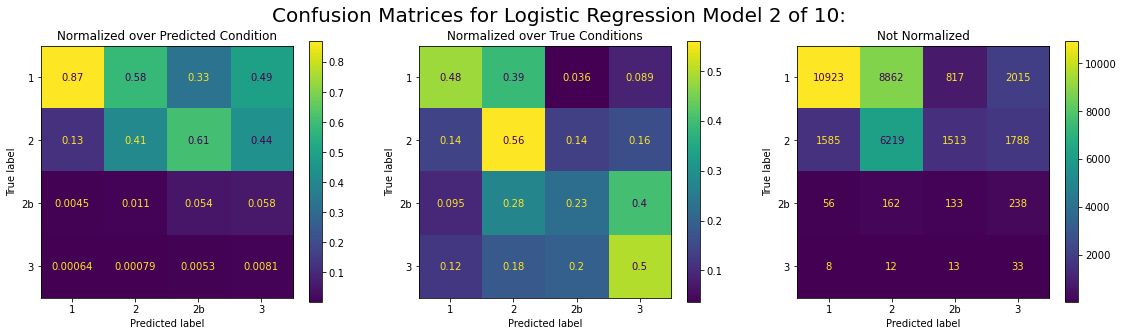

Logistic Regression Model 3 of 10:

              precision    recall  f1-score   support

           1   0.870238  0.479772  0.618537     22617
           2   0.406680  0.561369  0.471665     11105
          2b   0.051822  0.217317  0.083687       589
           3   0.007788  0.484848  0.015329        66

    accuracy                       0.501644     34377
   macro avg   0.334132  0.435827  0.297305     34377
weighted avg   0.704814  0.501644  0.560770     34377



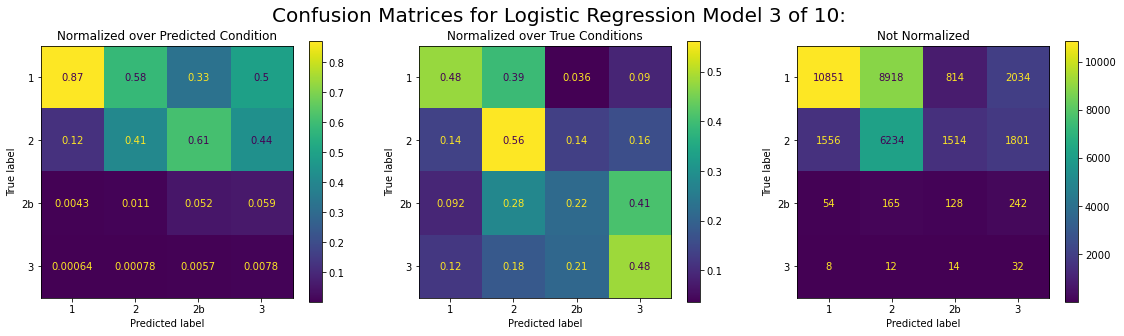

Logistic Regression Model 4 of 10:

              precision    recall  f1-score   support

           1   0.865895  0.486183  0.622721     22617
           2   0.406883  0.551463  0.468267     11105
          2b   0.052863  0.224109  0.085548       589
           3   0.007990  0.500000  0.015729        66

    accuracy                       0.502807     34377
   macro avg   0.333408  0.440439  0.298066     34377
weighted avg   0.702041  0.502807  0.562458     34377



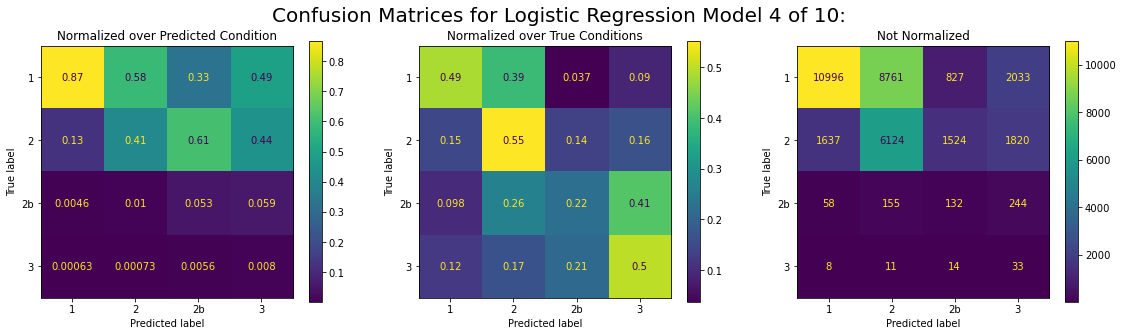

Logistic Regression Model 5 of 10:

              precision    recall  f1-score   support

           1   0.866740  0.485431  0.622322     22617
           2   0.407912  0.555245  0.470310     11105
          2b   0.051690  0.220713  0.083763       589
           3   0.008335  0.515152  0.016405        66

    accuracy                       0.503505     34377
   macro avg   0.333669  0.444135  0.298200     34377
weighted avg   0.702910  0.503505  0.562826     34377



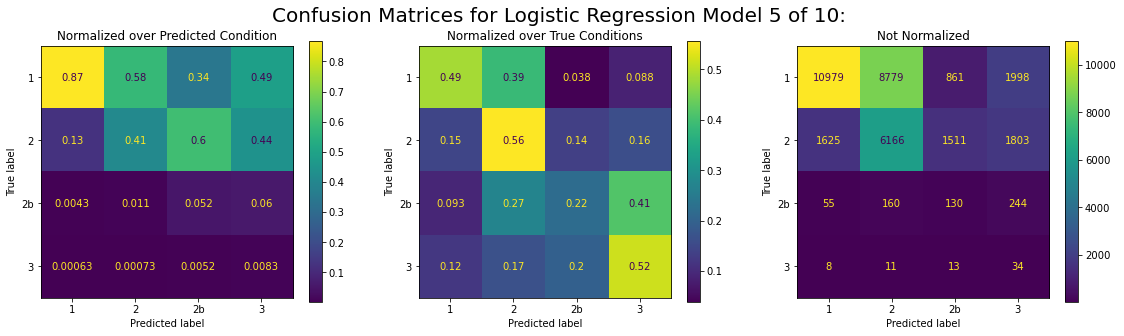

Logistic Regression Model 6 of 10:

              precision    recall  f1-score   support

           1   0.863651  0.488703  0.624199     22617
           2   0.406973  0.546601  0.466564     11105
          2b   0.049861  0.213922  0.080873       589
           3   0.007735  0.484848  0.015227        66

    accuracy                       0.502691     34377
   macro avg   0.332055  0.433519  0.296716     34377
weighted avg   0.700541  0.502691  0.562799     34377



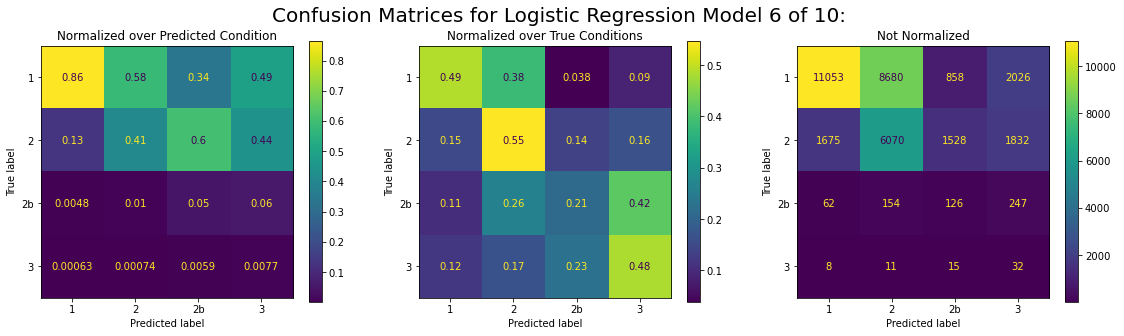

Logistic Regression Model 7 of 10:

              precision    recall  f1-score   support

           1   0.863981  0.488394  0.624033     22617
           2   0.407455  0.545340  0.466420     11105
          2b   0.048946  0.220713  0.080123       589
           3   0.007857  0.484848  0.015463        66

    accuracy                       0.502196     34377
   macro avg   0.332060  0.434824  0.296510     34377
weighted avg   0.700899  0.502196  0.562631     34377



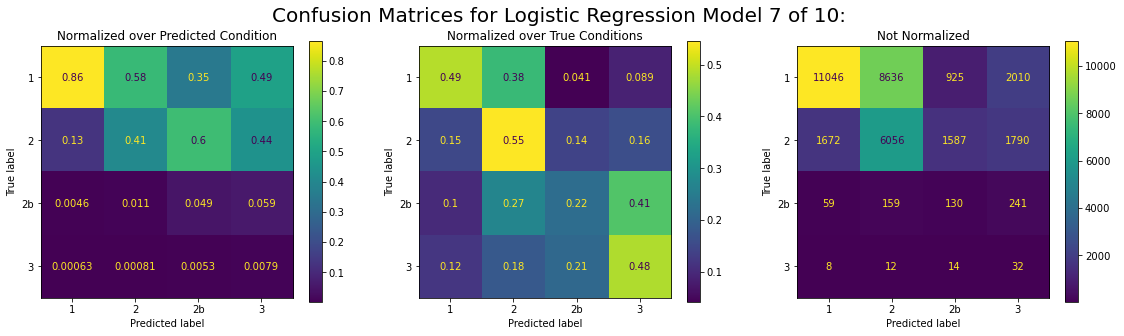

Logistic Regression Model 8 of 10:

              precision    recall  f1-score   support

           1   0.867922  0.483176  0.620768     22617
           2   0.407432  0.555876  0.470216     11105
          2b   0.050678  0.215620  0.082068       589
           3   0.008234  0.515152  0.016210        66

    accuracy                       0.502138     34377
   macro avg   0.333567  0.442456  0.297315     34377
weighted avg   0.703514  0.502138  0.561744     34377



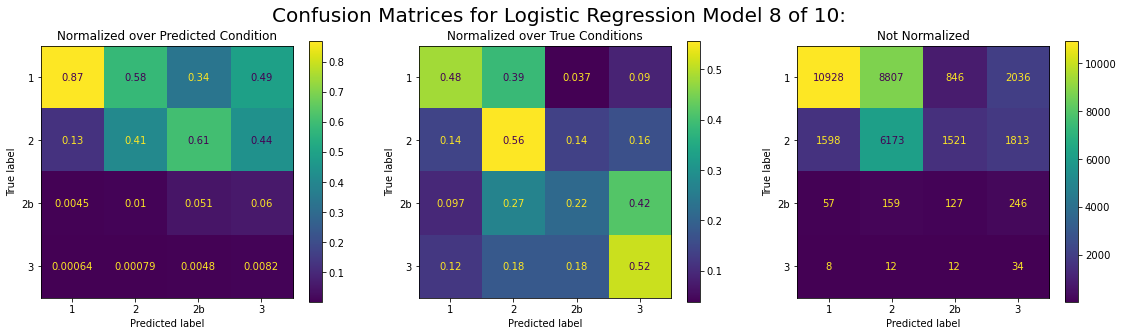

Logistic Regression Model 9 of 10:

              precision    recall  f1-score   support

           1   0.869190  0.481231  0.619483     22617
           2   0.406505  0.557136  0.470047     11105
          2b   0.051060  0.220713  0.082935       589
           3   0.008070  0.500000  0.015884        66

    accuracy                       0.501324     34377
   macro avg   0.333706  0.439770  0.297087     34377
weighted avg   0.704056  0.501324  0.560858     34377



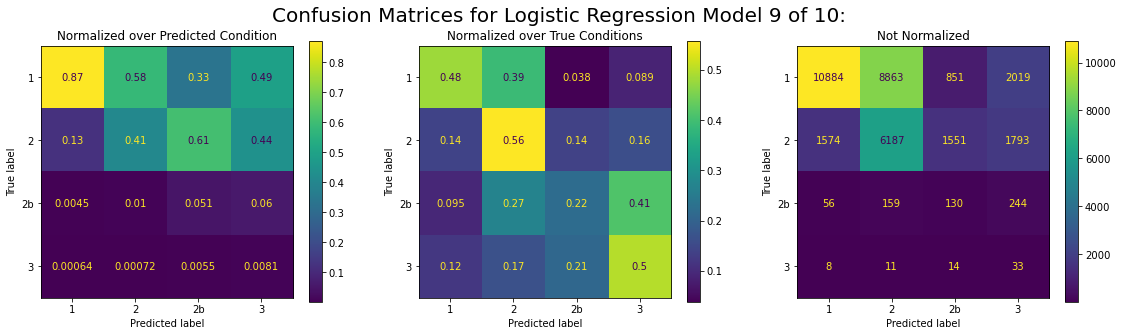

Logistic Regression Model 10 of 10:

              precision    recall  f1-score   support

           1   0.867088  0.485741  0.622666     22617
           2   0.407513  0.554885  0.469915     11105
          2b   0.051571  0.217317  0.083360       589
           3   0.008041  0.500000  0.015827        66

    accuracy                       0.503505     34377
   macro avg   0.333553  0.439486  0.297942     34377
weighted avg   0.703007  0.503505  0.562917     34377



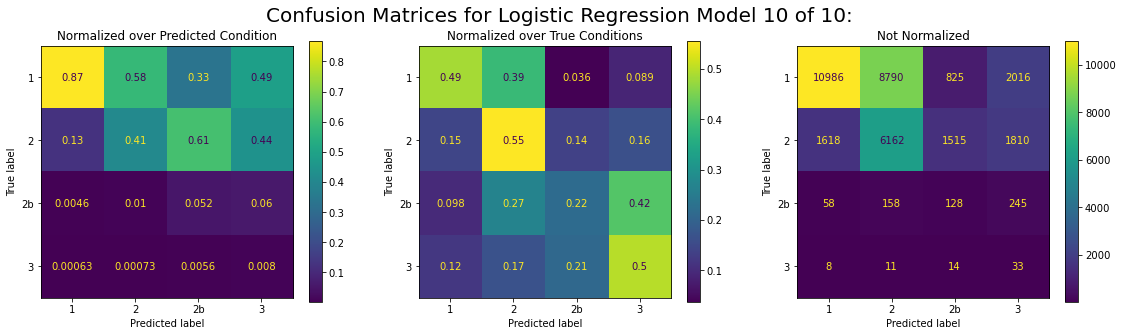

In [68]:
# For each logistic regression classifier in the cross-validation, print the macro recall, score report, and confusion matrices.
number_of_models = len(logistic_regression_scores['estimator'])
labels = ['1', '2', '2b', '3']
for index, logistic_regression_clf in zip(range(len(logistic_regression_scores['estimator'])), logistic_regression_scores['estimator']):
    y_test_predicted = logistic_regression_clf.predict(X_test)
    print('Logistic Regression Model %d of %d:' % (index + 1, number_of_models))
    print()
    print(classification_report(y_test, y_test_predicted, labels=labels, target_names=labels, digits=6))
        
    # Create a figure.
    fig = plt.figure(num=str(index + 1), figsize=(6.4 * 3, 4.8))
    fig.suptitle('Confusion Matrices for Logistic Regression Model %d of %d:' % (index + 1, number_of_models), fontsize=20)
    
    ax = plt.subplot(1, 3, 1)
    ax.set_title("Normalized over Predicted Condition", fontsize=12)
    plot_confusion_matrix(logistic_regression_clf, X_test, y_test, labels=labels, display_labels=labels, normalize='pred', ax=ax)
    
    ax = plt.subplot(1, 3, 2)
    ax.set_title("Normalized over True Conditions", fontsize=12)
    plot_confusion_matrix(logistic_regression_clf, X_test, y_test, labels=labels, display_labels=labels, normalize='true', ax=ax)
    
    ax = plt.subplot(1, 3, 3)
    ax.set_title("Not Normalized", fontsize=12)
    plot_confusion_matrix(logistic_regression_clf, X_test, y_test, labels=labels, display_labels=labels, normalize=None, ax=ax)

    plt.show()

In [69]:
print_elapsed_time(notebook_start_time)

Elapsed time is 617.7570937710116 seconds.


In [70]:
# Report statistics of the models built for each fold of the cross-validation.
print('Support Vector Machine Cross-validation Scores:')
print()
for key in sorted(linear_svc_scores.keys()):
    if key != 'estimator':
        print('%s: mean = %f, std = %f' % (key, np.mean(linear_svc_scores[key]), np.std(linear_svc_scores[key])), sep='')
        print('%s :%s' % (key, linear_svc_scores[key]), sep='')
        print()

Support Vector Machine Cross-validation Scores:

fit_time: mean = 0.516152, std = 0.149546
fit_time :[0.56199861 0.73849177 0.41515827 0.38469577 0.46963334 0.5974822
 0.69214416 0.65970349 0.38504267 0.2571671 ]

score_time: mean = 0.113013, std = 0.043789
score_time :[0.0822134  0.16806436 0.07770061 0.13938975 0.10321593 0.18583703
 0.16188288 0.07718015 0.0691061  0.06554317]

test_f1_macro: mean = 0.468975, std = 0.012572
test_f1_macro :[0.47804961 0.47331531 0.46642162 0.45073417 0.49228077 0.46548283
 0.4834582  0.46029787 0.45169191 0.46801896]

test_f1_weighted: mean = 0.468975, std = 0.012572
test_f1_weighted :[0.47804961 0.47331531 0.46642162 0.45073417 0.49228077 0.46548283
 0.4834582  0.46029787 0.45169191 0.46801896]

test_precision_macro: mean = 0.499901, std = 0.018826
test_precision_macro :[0.5147147  0.50105059 0.49558339 0.48166763 0.53811061 0.49106459
 0.52534005 0.48099571 0.48541011 0.48507486]

test_precision_weighted: mean = 0.499901, std = 0.018826
test_precis

Support Vector Machine Model 1 of 10:

              precision    recall  f1-score   support

           1   0.871305  0.479551  0.618623     22617
           2   0.408025  0.570464  0.475761     11105
          2b   0.055717  0.162988  0.083045       589
           3   0.007692  0.545455  0.015171        66

    accuracy                       0.503622     34377
   macro avg   0.335685  0.439614  0.298150     34377
weighted avg   0.706017  0.503622  0.562138     34377



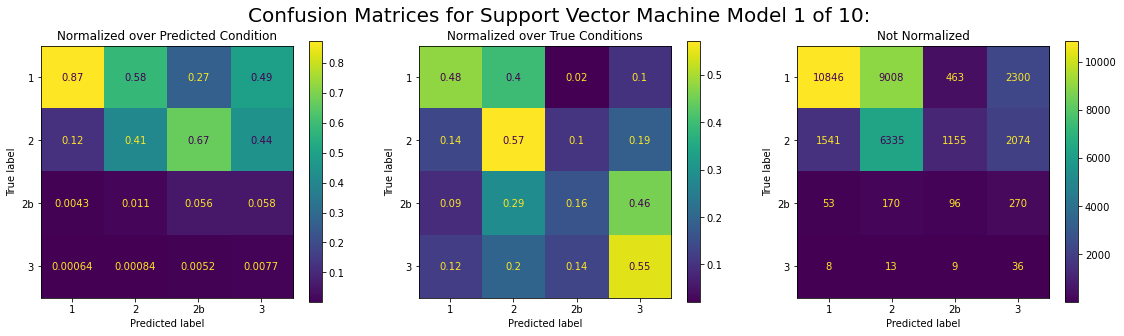

Support Vector Machine Model 2 of 10:

              precision    recall  f1-score   support

           1   0.871782  0.479197  0.618448     22617
           2   0.407119  0.583971  0.479766     11105
          2b   0.063703  0.162988  0.091603       589
           3   0.007540  0.515152  0.014863        66

    accuracy                       0.507694     34377
   macro avg   0.337536  0.435327  0.301170     34377
weighted avg   0.706175  0.507694  0.563464     34377



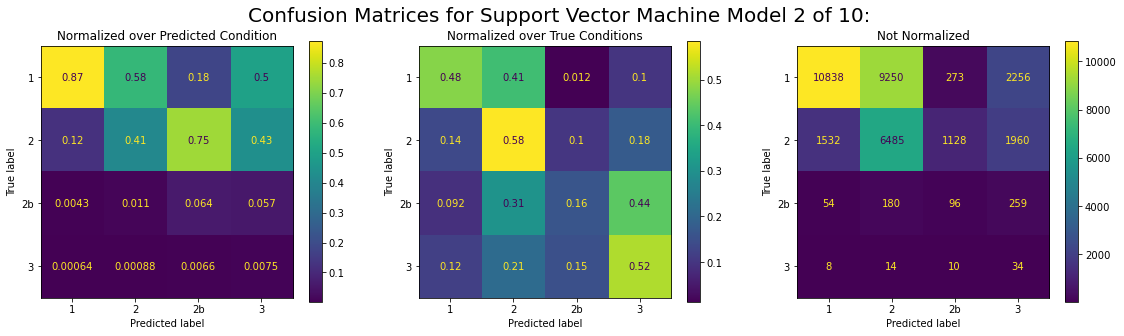

Support Vector Machine Model 3 of 10:

              precision    recall  f1-score   support

           1   0.872217  0.478047  0.617599     22617
           2   0.406532  0.580639  0.478232     11105
          2b   0.062078  0.156197  0.088846       589
           3   0.007762  0.545455  0.015306        66

    accuracy                       0.505803     34377
   macro avg   0.337147  0.440085  0.299996     34377
weighted avg   0.706244  0.505803  0.562363     34377



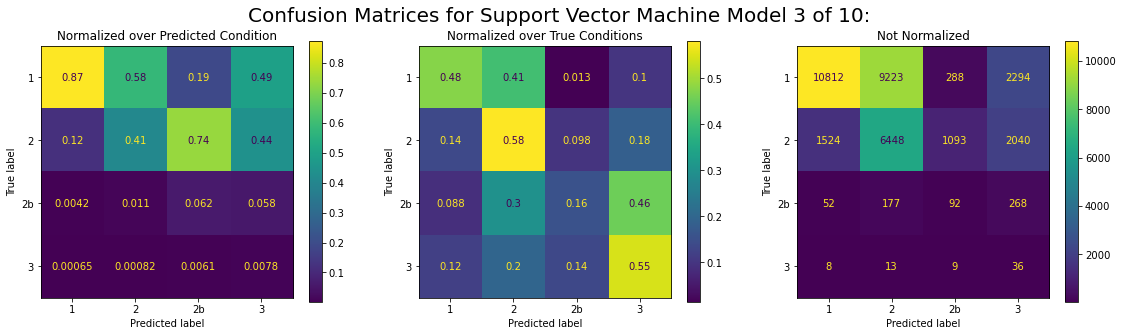

Support Vector Machine Model 4 of 10:

              precision    recall  f1-score   support

           1   0.869906  0.481319  0.619738     22617
           2   0.408186  0.566682  0.474549     11105
          2b   0.056229  0.173175  0.084894       589
           3   0.007772  0.545455  0.015326        66

    accuracy                       0.503738     34377
   macro avg   0.335523  0.441658  0.298627     34377
weighted avg   0.705157  0.503738  0.562512     34377



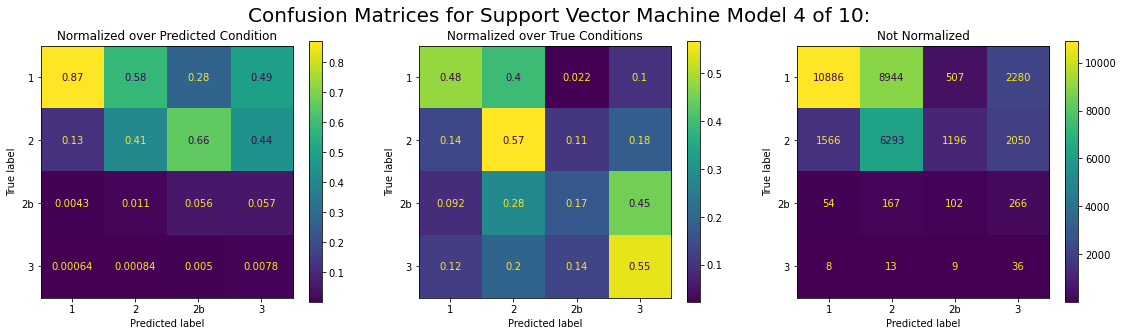

Support Vector Machine Model 5 of 10:

              precision    recall  f1-score   support

           1   0.870298  0.481806  0.620240     22617
           2   0.408545  0.563980  0.473841     11105
          2b   0.054126  0.171477  0.082281       589
           3   0.007725  0.545455  0.015235        66

    accuracy                       0.503156     34377
   macro avg   0.335174  0.440679  0.297899     34377
weighted avg   0.705495  0.503156  0.562569     34377



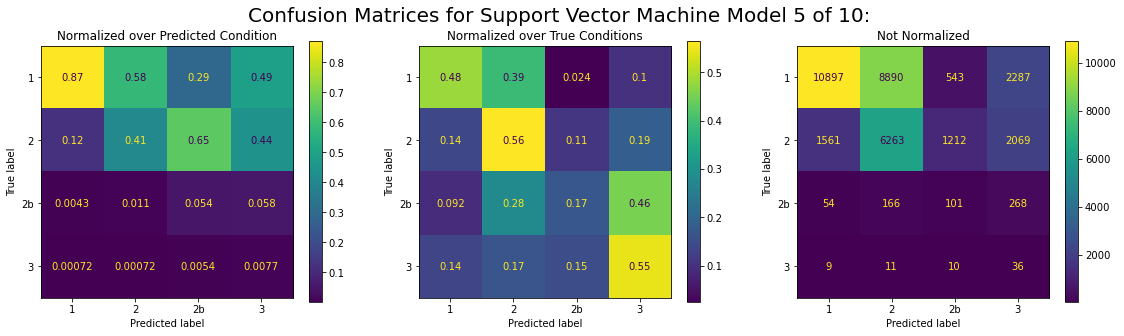

Support Vector Machine Model 6 of 10:

              precision    recall  f1-score   support

           1   0.866709  0.484724  0.621732     22617
           2   0.408510  0.552454  0.469701     11105
          2b   0.049701  0.183362  0.078204       589
           3   0.007935  0.545455  0.015642        66

    accuracy                       0.501556     34377
   macro avg   0.333214  0.441498  0.296320     34377
weighted avg   0.703047  0.501556  0.562144     34377



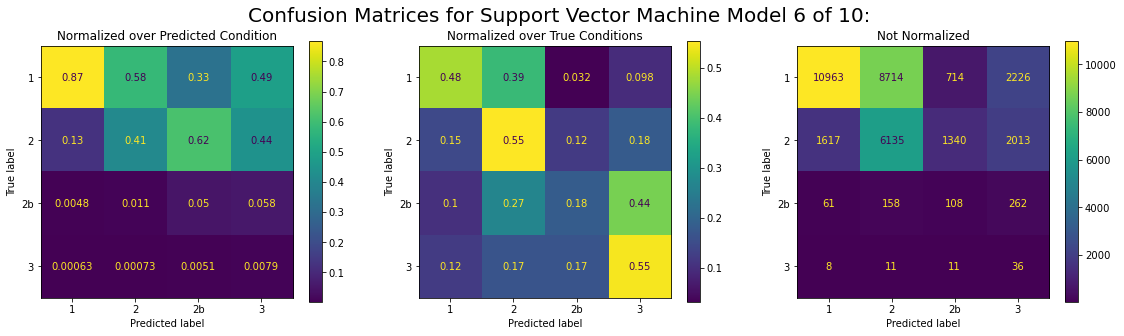

Support Vector Machine Model 7 of 10:

              precision    recall  f1-score   support

           1   0.872148  0.478357  0.617840     22617
           2   0.406094  0.577308  0.476796     11105
          2b   0.060748  0.154499  0.087207       589
           3   0.007681  0.545455  0.015148        66

    accuracy                       0.504902     34377
   macro avg   0.336668  0.438905  0.299248     34377
weighted avg   0.706034  0.504902  0.562029     34377



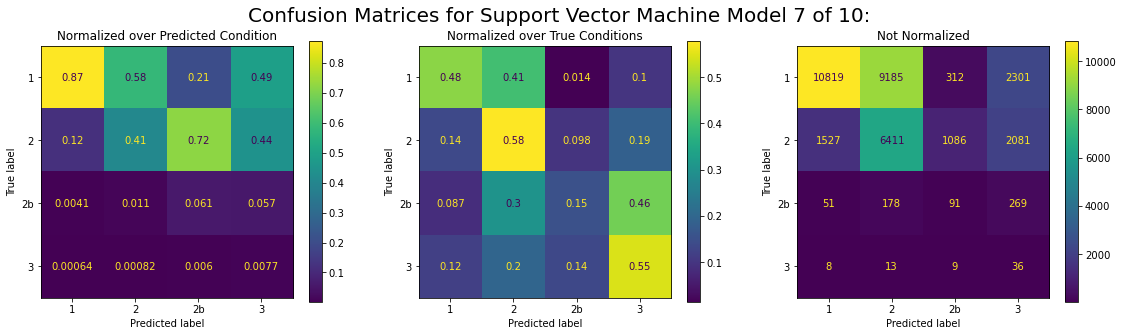

Support Vector Machine Model 8 of 10:

              precision    recall  f1-score   support

           1   0.869962  0.480966  0.619458     22617
           2   0.407153  0.577127  0.477464     11105
          2b   0.061771  0.152801  0.087977       589
           3   0.007914  0.560606  0.015609        66

    accuracy                       0.506560     34377
   macro avg   0.336700  0.442875  0.300127     34377
weighted avg   0.704956  0.506560  0.563324     34377



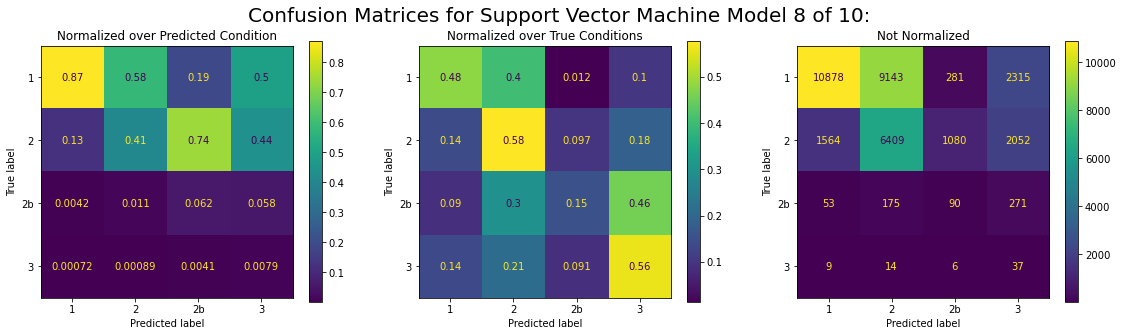

Support Vector Machine Model 9 of 10:

              precision    recall  f1-score   support

           1   0.871840  0.477340  0.616914     22617
           2   0.407232  0.571995  0.475752     11105
          2b   0.057143  0.169779  0.085507       589
           3   0.007749  0.545455  0.015280        66

    accuracy                       0.502778     34377
   macro avg   0.335991  0.441142  0.298363     34377
weighted avg   0.706138  0.502778  0.561054     34377



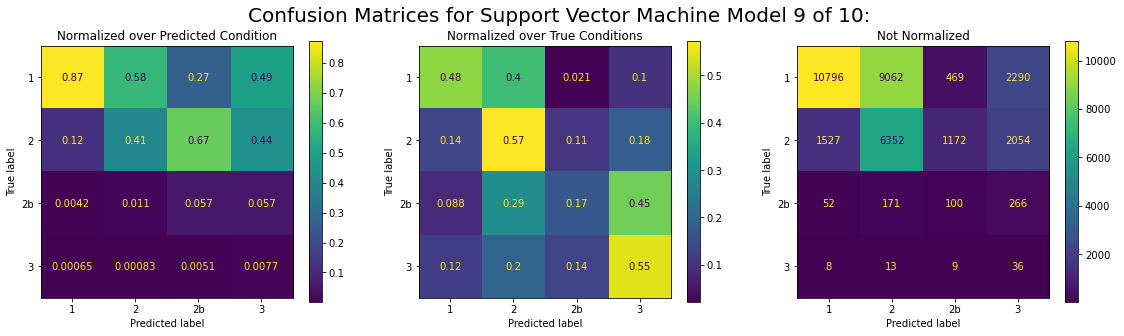

Support Vector Machine Model 10 of 10:

              precision    recall  f1-score   support

           1   0.871144  0.480656  0.619501     22617
           2   0.408105  0.564070  0.473577     11105
          2b   0.054527  0.185059  0.084235       589
           3   0.007473  0.515152  0.014731        66

    accuracy                       0.502603     34377
   macro avg   0.335312  0.436234  0.298011     34377
weighted avg   0.705916  0.502603  0.562030     34377



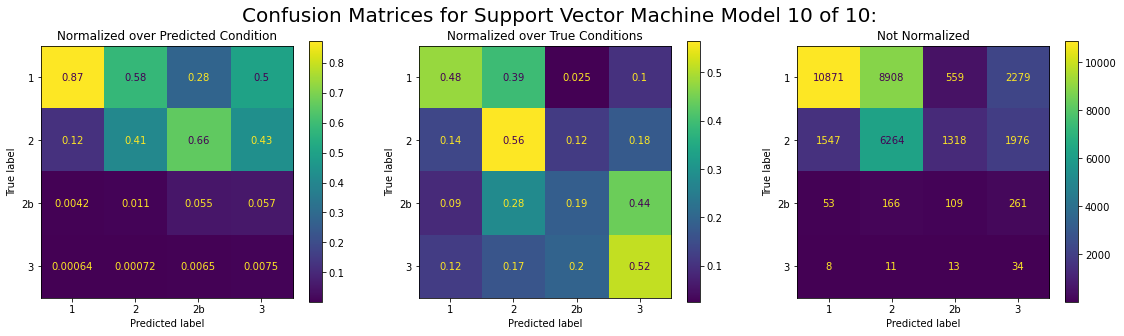

In [71]:
# For each support vector machine classifier in the cross-validation, print the score report and confusion matrices.
number_of_models = len(linear_svc_scores['estimator'])
labels = ['1', '2', '2b', '3']
for index, linear_svc_clf in zip(range(len(linear_svc_scores['estimator'])), linear_svc_scores['estimator']):
    y_test_predicted = linear_svc_clf.predict(X_test)
    print('Support Vector Machine Model %d of %d:' % (index + 1, number_of_models))
    print()
    print(classification_report(y_test, y_test_predicted, labels=labels, target_names=labels, digits=6))
        
    # Create a figure.
    fig = plt.figure(num=str(index + 1), figsize=(6.4 * 3, 4.8))
    fig.suptitle('Confusion Matrices for Support Vector Machine Model %d of %d:' % (index + 1, number_of_models), fontsize=20)
    
    ax = plt.subplot(1,3,1)
    ax.set_title("Normalized over Predicted Condition", fontsize=12)
    plot_confusion_matrix(linear_svc_clf, X_test, y_test, labels=labels, display_labels=labels, normalize='pred', ax=ax)
    
    ax = plt.subplot(1,3,2)
    ax.set_title("Normalized over True Conditions", fontsize=12)
    plot_confusion_matrix(linear_svc_clf, X_test, y_test, labels=labels, display_labels=labels, normalize='true', ax=ax)
    
    ax = plt.subplot(1,3,3)
    ax.set_title("Not Normalized", fontsize=12)
    plot_confusion_matrix(linear_svc_clf, X_test, y_test, labels=labels, display_labels=labels, normalize=None, ax=ax)
    
    plt.show()

In [72]:
print_elapsed_time(notebook_start_time)

Elapsed time is 694.9443239320535 seconds.


In [73]:
# Report statistics of the models built for each fold of the cross-validation.
print('k-Nearest Neighbors Cross-validation Scores:')
print()
for key in sorted(k_neighbors_scores.keys()):
    if key != 'estimator':
        print('%s: mean = %f, std = %f' % (key, np.mean(k_neighbors_scores[key]), np.std(k_neighbors_scores[key])), sep='')
        print('%s :%s' % (key, k_neighbors_scores[key]), sep='')
        print()

k-Nearest Neighbors Cross-validation Scores:

fit_time: mean = 0.089096, std = 0.034998
fit_time :[0.07158089 0.07520509 0.06228065 0.13390017 0.16410589 0.03902197
 0.10783124 0.08758569 0.06690478 0.0825417 ]

score_time: mean = 3.174703, std = 0.271713
score_time :[3.26179934 3.34756732 3.52902842 3.36672115 3.17797184 2.87993073
 3.04784226 3.51928949 2.96394563 2.65293479]

test_f1_macro: mean = 0.504289, std = 0.011948
test_f1_macro :[0.53059648 0.51917017 0.49929847 0.50059081 0.49733527 0.51038753
 0.49275118 0.49879646 0.50471514 0.48924404]

test_f1_weighted: mean = 0.504289, std = 0.011948
test_f1_weighted :[0.53059648 0.51917017 0.49929847 0.50059081 0.49733527 0.51038753
 0.49275118 0.49879646 0.50471514 0.48924404]

test_neg_log_loss: mean = -2.205192, std = 0.265512
test_neg_log_loss :[-1.8285102  -2.22217138 -2.24132067 -2.18708855 -2.56354216 -2.23988935
 -2.70500206 -1.9341295  -1.87936865 -2.25090207]

test_precision_macro: mean = 0.508724, std = 0.012374
test_precis

k-Nearest Neighbor Model 1 of 10:

              precision    recall  f1-score   support

           1   0.845287  0.507539  0.634251     22617
           2   0.408269  0.491760  0.446142     11105
          2b   0.046697  0.298812  0.080771       589
           3   0.008215  0.454545  0.016138        66

    accuracy                       0.498764     34377
   macro avg   0.327117  0.438164  0.294326     34377
weighted avg   0.688825  0.498764  0.562816     34377



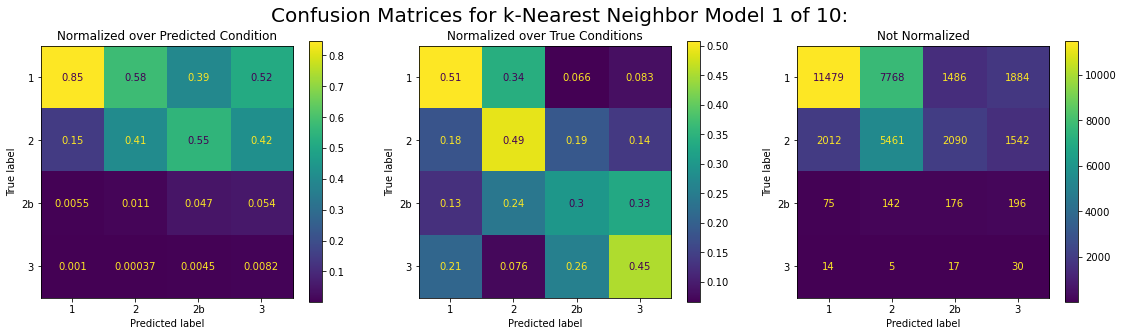

k-Nearest Neighbor Model 2 of 10:

              precision    recall  f1-score   support

           1   0.846256  0.504753  0.632343     22617
           2   0.407987  0.493111  0.446528     11105
          2b   0.049261  0.305603  0.084846       589
           3   0.008397  0.484848  0.016508        66

    accuracy                       0.497542     34377
   macro avg   0.327975  0.447079  0.295056     34377
weighted avg   0.689416  0.497542  0.561755     34377



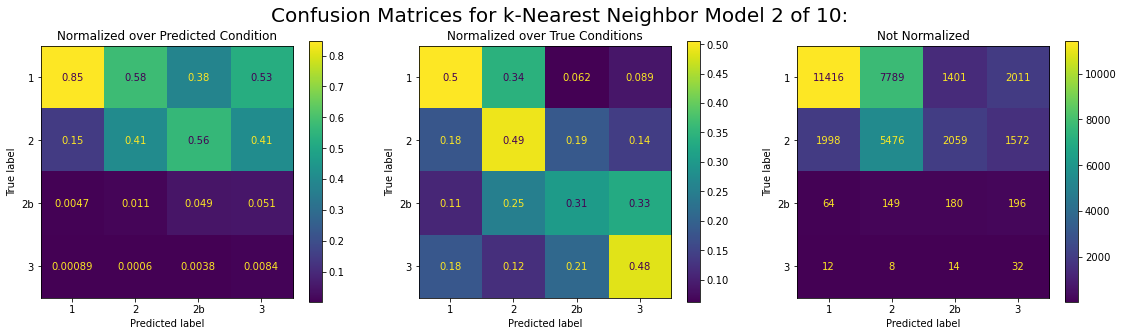

k-Nearest Neighbor Model 3 of 10:

              precision    recall  f1-score   support

           1   0.849955  0.503427  0.632327     22617
           2   0.404923  0.490320  0.443548     11105
          2b   0.046612  0.310696  0.081063       589
           3   0.008592  0.469697  0.016875        66

    accuracy                       0.495826     34377
   macro avg   0.327521  0.443535  0.293454     34377
weighted avg   0.690814  0.495826  0.560718     34377



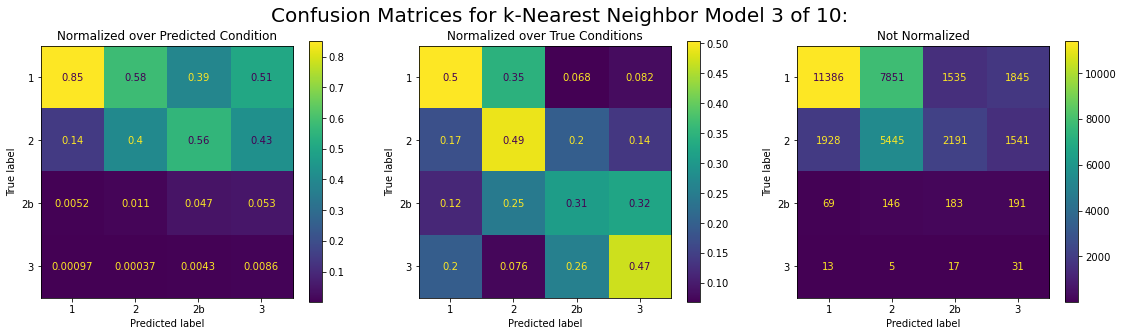

k-Nearest Neighbor Model 4 of 10:

              precision    recall  f1-score   support

           1   0.848210  0.499580  0.628805     22617
           2   0.404639  0.472850  0.436093     11105
          2b   0.047643  0.322581  0.083024       589
           3   0.007578  0.469697  0.014915        66

    accuracy                       0.487855     34377
   macro avg   0.327017  0.441177  0.290709     34377
weighted avg   0.689590  0.487855  0.556023     34377



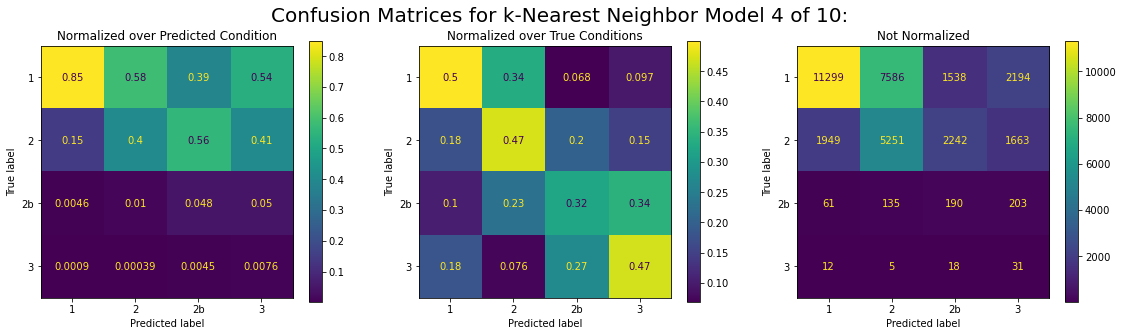

k-Nearest Neighbor Model 5 of 10:

              precision    recall  f1-score   support

           1   0.838847  0.515762  0.638776     22617
           2   0.404997  0.477353  0.438208     11105
          2b   0.047583  0.320883  0.082877       589
           3   0.008798  0.454545  0.017261        66

    accuracy                       0.499898     34377
   macro avg   0.325056  0.442136  0.294280     34377
weighted avg   0.683547  0.499898  0.563267     34377



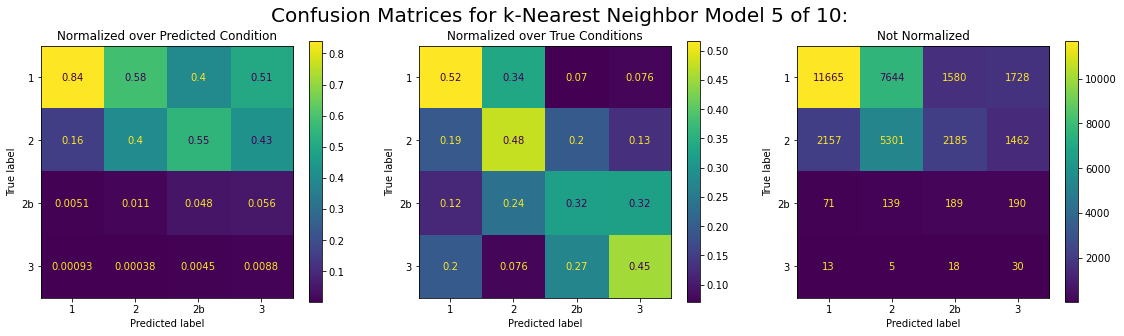

k-Nearest Neighbor Model 6 of 10:

              precision    recall  f1-score   support

           1   0.835183  0.525843  0.645359     22617
           2   0.410223  0.459613  0.433516     11105
          2b   0.047778  0.315789  0.082999       589
           3   0.007891  0.454545  0.015512        66

    accuracy                       0.500713     34377
   macro avg   0.325269  0.438948  0.294346     34377
weighted avg   0.682826  0.500713  0.566082     34377



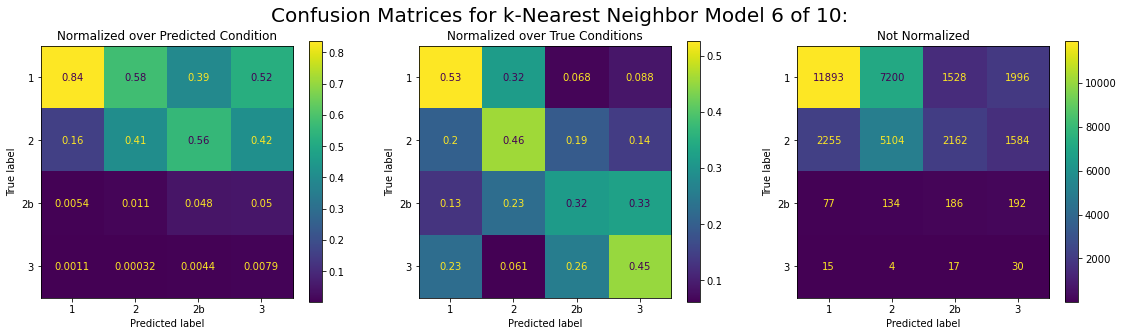

k-Nearest Neighbor Model 7 of 10:

              precision    recall  f1-score   support

           1   0.830660  0.528983  0.646353     22617
           2   0.407050  0.448176  0.426624     11105
          2b   0.046688  0.324278  0.081624       589
           3   0.008206  0.454545  0.016120        66

    accuracy                       0.499229     34377
   macro avg   0.323151  0.438996  0.292680     34377
weighted avg   0.678808  0.499229  0.564487     34377



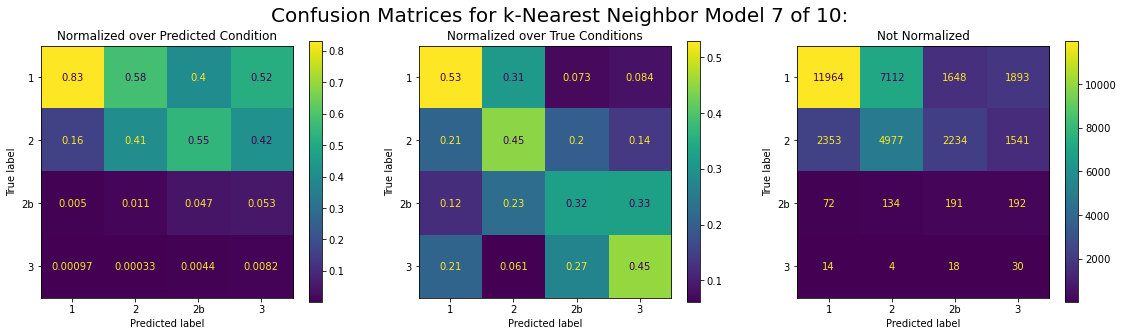

k-Nearest Neighbor Model 8 of 10:

              precision    recall  f1-score   support

           1   0.838511  0.516779  0.639457     22617
           2   0.405267  0.469788  0.435149     11105
          2b   0.047743  0.312394  0.082827       589
           3   0.008084  0.454545  0.015886        66

    accuracy                       0.497978     34377
   macro avg   0.324901  0.438377  0.293330     34377
weighted avg   0.683414  0.497978  0.562724     34377



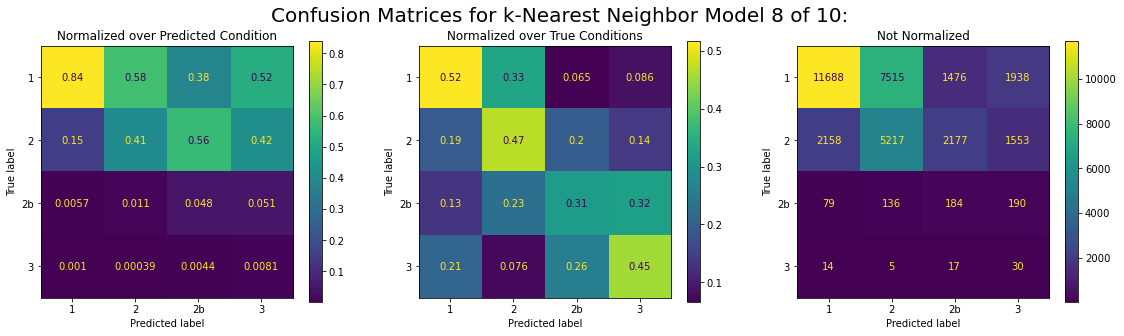

k-Nearest Neighbor Model 9 of 10:

              precision    recall  f1-score   support

           1   0.833672  0.525888  0.644941     22617
           2   0.413289  0.465466  0.437828     11105
          2b   0.049281  0.314092  0.085195       589
           3   0.008054  0.469697  0.015837        66

    accuracy                       0.502633     34377
   macro avg   0.326074  0.443786  0.295950     34377
weighted avg   0.682849  0.502633  0.567238     34377



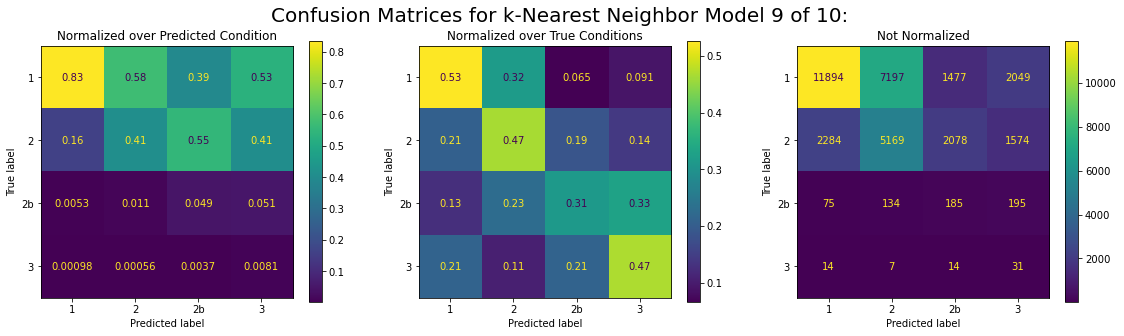

k-Nearest Neighbor Model 10 of 10:

              precision    recall  f1-score   support

           1   0.837461  0.512800  0.636099     22617
           2   0.406595  0.480774  0.440584     11105
          2b   0.049589  0.297114  0.084993       589
           3   0.007756  0.454545  0.015252        66

    accuracy                       0.498647     34377
   macro avg   0.325350  0.436308  0.294232     34377
weighted avg   0.683184  0.498647  0.562307     34377



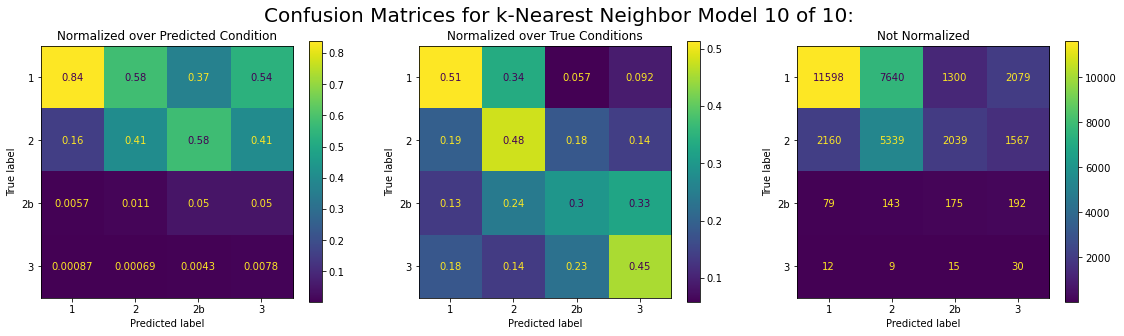

In [74]:
# For each k-Nearest Neighbor classifier in the cross-validation, print the macro recall, score report, and confusion matrices.
number_of_models = len(k_neighbors_scores['estimator'])
labels = ['1', '2', '2b', '3']
for index, knn_clf in zip(range(len(k_neighbors_scores['estimator'])), k_neighbors_scores['estimator']):
    y_test_predicted = knn_clf.predict(X_test)
    print('k-Nearest Neighbor Model %d of %d:' % (index + 1, number_of_models))
    print()
    print(classification_report(y_test, y_test_predicted, labels=labels, target_names=labels, digits=6))
        
    # Create a figure.
    fig = plt.figure(num=str(index + 1), figsize=(6.4 * 3, 4.8))
    fig.suptitle('Confusion Matrices for k-Nearest Neighbor Model %d of %d:' % (index + 1, number_of_models), fontsize=20)
    
    ax = plt.subplot(1, 3, 1)
    ax.set_title("Normalized over Predicted Condition", fontsize=12)
    plot_confusion_matrix(knn_clf, X_test, y_test, labels=labels, display_labels=labels, normalize='pred', ax=ax)
    
    ax = plt.subplot(1, 3, 2)
    ax.set_title("Normalized over True Conditions", fontsize=12)
    plot_confusion_matrix(knn_clf, X_test, y_test, labels=labels, display_labels=labels, normalize='true', ax=ax)
    
    ax = plt.subplot(1, 3, 3)
    ax.set_title("Not Normalized", fontsize=12)
    plot_confusion_matrix(knn_clf, X_test, y_test, labels=labels, display_labels=labels, normalize=None, ax=ax)

    plt.show()

In [75]:
print('All reports and graphics generated in %f seconds.' % (elapsed_time(t0)))

All reports and graphics generated in 1733.168409 seconds.


In [76]:
print_elapsed_time(notebook_start_time)

Elapsed time is 2261.0483899799874 seconds.
